In [1]:
from __future__ import print_function, division, absolute_import

# Challenges of Streaming Data:
Building an ANTARES-like Pipeline for Data Management and Discovery
========

#### Version 0.1

***
By AA Miller 2017 Apr 10

As we just saw in Gautham's lecture - LSST will produce an unprecedented volume of time-domain information for the astronomical sky. $>37$ trillion individual photometric measurements will be recorded. While the vast, vast majority of these measurements will simply confirm the status quo, some will represent rarities that have never been seen before (e.g., LSST may be the first telescope to discover the electromagnetic counterpart to a LIGO graviational wave event), which the community will need to know about in ~real time. 

Storing, filtering, and serving this data is going to be a huge <del>nightmare</del> challenge. ANTARES, as detailed by Gautham, is one proposed solution to this challenge. In this exercise you will build a miniature version of ANTARES, which will require the application of several of the lessons from earlier this week. Many of the difficult, and essential, steps necessary for ANTARES will be skipped here as they are too time consuming or beyond the scope of what we have previously covered. We will point out these challenges are we come across them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) Light Curve Data

We begin by ignoring the streaming aspect of the problem (we will come back to that later) and instead we will work with full light curves. The collection of light curves has been curated by Gautham and like LSST it features objects of different types covering a large range in brightness and observations in multiple filters taken at different cadences.

As the focus of this exercise is the construction of a data management pipeline, we have already created a Python `class` to read in the data and store light curves as objects. The data are stored in flat text files with the following format:

|t               |pb   |flux        |dflux       |
|:--------------:|:---:|:----------:|-----------:|
|   56254.160000 |  i  |   6.530000 |   4.920000 |
|   56254.172000 |  z  |   4.113000 |   4.018000 |
|   56258.125000 |  g  |   5.077000 |  10.620000 |
|   56258.141000 |  r  |   6.963000 |   5.060000 |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |

and names `FAKE0XX.dat` where the `XX` is a running index from `01` to `99`. 

**Problem 1a**

Read in the data for the first light curve file and plot the $g'$ light curve for that source.

<IPython.core.display.Javascript object>


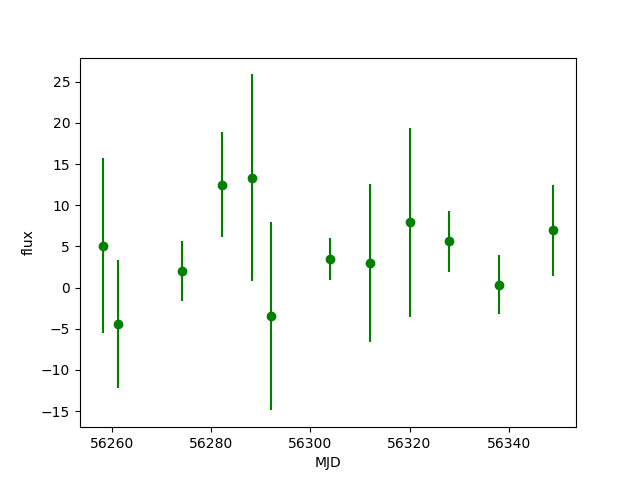

In [22]:
# execute this cell

# XXX note - figure out how data handling will work for this file

lc = pd.read_csv('testset_for_LSST_DSFP/FAKE001.dat', delim_whitespace=True, comment = '#')

plt.errorbar(np.array(lc['t'].ix[lc['pb'] == 'g']), 
             np.array(lc['flux'].ix[lc['pb'] == 'g']), 
             np.array(lc['dflux'].ix[lc['pb'] == 'g']), fmt = 'o', color = 'green')
plt.xlabel('MJD')
plt.ylabel('flux')

As we have many light curve files (in principle as many as 37 billion...), we will define a light curve class to ease our handling of the data.

** Problem 1b** 

Fix the `lc` class definition below.

*Hint* - the only purpose of this problem is to make sure you actually read each line of code below, it is not intended to be difficult.

In [20]:
class ANTARESlc():
    '''Light curve object for NOAO formatted data'''
    
    def __init__(self, filename):
        '''Read in light curve data'''
        DFlc = pd.read_csv(filename, delim_whitespace=True, comment = '#')
        self.DFlc = DFlc
        self.filename = filename
        
    def plot_multicolor_lc(self):
        '''Plot the 4 band light curve'''
        fig, ax = plt.subplots()
        g = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'g'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'g'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g'],
                     fmt = 'o', color = '#78A5A3', label = r"$g'$")
        r = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'r'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'r'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r'],
                     fmt = 'o', color = '#CE5A57', label = r"$r'$")
        i = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'i'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'i'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i'],
                     fmt = 'o', color = '#E1B16A', label = r"$i'$")
        z = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'z'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'z'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z'],
                     fmt = 'o', color = '#444C5C', label = r"$z'$")
        ax.legend(fancybox = True)
        ax.set_xlabel(r"$\mathrm{MJD}$")
        ax.set_ylabel(r"$\mathrm{flux}$")

**Problem 1c**

Confirm the corrections made in **1b** by plotting the multiband light curve for the source `FAKE010`.

<IPython.core.display.Javascript object>


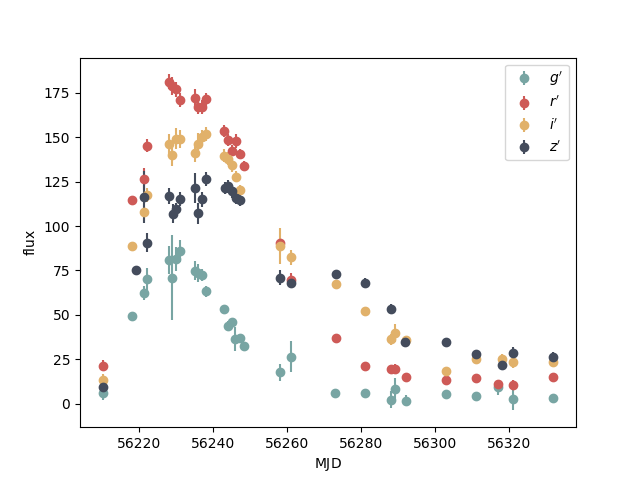

In [21]:
lc = ANTARESlc('testset_for_LSST_DSFP/FAKE010.dat')

lc.plot_multicolor_lc()

One thing that we brushed over previously is that the brightness measurements have units of flux, rather than the traditional use of magnitudes. The reason for this is that LSST will measure flux variations via image differencing, which will for some sources in some filters result in a measurement of *negative flux*. (You may have already noticed this in **1a**.) Statistically there is nothing wrong with such a measurement, but it is impossible to convert a negative flux into a magnitude. Thus we will use flux measurements throughout this exercise. [Aside - if you are bored during the next break, I'd be happy to rant about why we should have ditched the magnitude system years ago.]

Using flux measurements will allow us to make unbiased measurements of the statistical distributions of the variations of the sources we care about. 

**Problem 1d**

What is `FAKE010` the source that is plotted above?

*Hint 1* - if you have no idea that's fine, move on.

*Hint 2* - ask Szymon or Tomas... 

**Solution 1d**

`FAKE010` is a transient, as can be seen by the rapid rise followed by a gradual decline in the light curve. In this particular case, we can further guess that `FAKE010` is a Type Ia supernova due to the secondary maxima in the $i'$ and $z'$ light curves. These secondary peaks are not present in any other known type of transient.

**Problem 1e**

To get a better sense of the data, plot the multiband light curves for sources `FAKE060` and `FAKE073`.

<IPython.core.display.Javascript object>


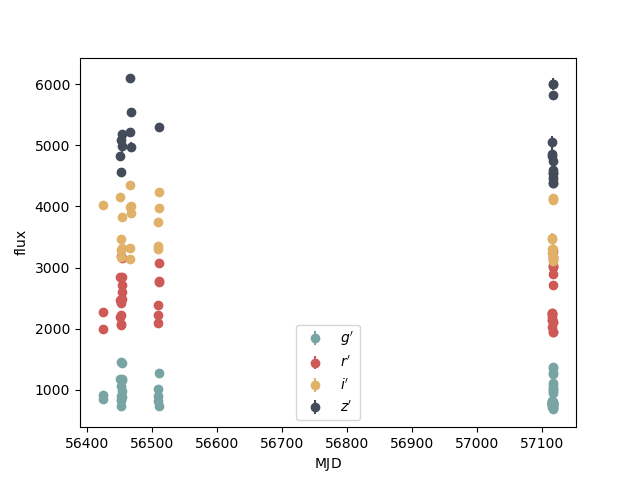

<IPython.core.display.Javascript object>


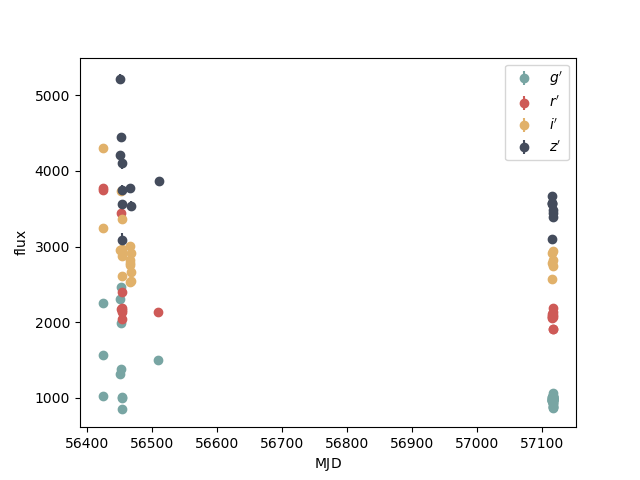

In [30]:
lc59 = ANTARESlc("testset_for_LSST_DSFP/FAKE060.dat")
lc59.plot_multicolor_lc()

lc60 = ANTARESlc("testset_for_LSST_DSFP/FAKE073.dat")
lc60.plot_multicolor_lc()

## Problem 2) Data Preparation

While we could create a database table that includes every single photometric measurement made by LSST, this ~37 trillion row db would be enormous without providing a lot of added value beyond the raw flux measurements [while this table is necessary, alternative tables may provide more useful]. Furthermore, extracting individual light curves from such a database will be slow. Instead, we are going to develop summary statistics for every source which will make it easier to select individual sources and develop classifiers to identify objects of interest.  

Below we will redefine the `ANTARESlc` class to include additional methods so we can (eventually) store summary statistics in a database table. In the interest of time, we limit the summary statistics to a relatively small list all of which have been shown to be useful for classification (see [Richards et al. 2011](http://iopscience.iop.org/article/10.1088/0004-637X/733/1/10/meta) for further details). The statistics that we include (for now) are: 

1. `Std` -- the standard deviation of the flux measurements 
2. `Amp` -- the amplitude of flux deviations
3. `MAD` -- the median absolute deviation of the flux measurements
4. `beyond1std` -- the fraction of flux measurements beyond 1 standard deviation
5. the mean $g' - r'$, $r' - i'$, and $i' - z'$ color


**Problem 2a**

Complete the mean color module in the `ANTARESlc` class. Feel free to use the other modules as a template for your work. 

*Hint*/*food for thought* - if a source is observed in different filters but the observations are not simultaneous (or quasi-simultaneous), what is the meaning of a "mean color"?

*Solution to food for thought* - in this case we simply want you to take the mean flux in each filter and create a statistic that is $-2.5 \log \frac{\langle f_X \rangle}{\langle f_{Y} \rangle}$, where ${\langle f_{Y} \rangle}$ is the mean flux in band $Y$, while $\langle f_X \rangle$ is the mean flux in band $X$, which can be $g', r', i', z'$. Note that our use of image-difference flux measurements, which can be negative, means you'll need to add some form a case excpetion if $\langle f_X \rangle$ or $\langle f_Y \rangle$ is negative. In these cases set the color to -999.

In [136]:
class ANTARESlc():
    '''Light curve object for NOAO formatted data'''
    
    def __init__(self, filename):
        '''Read in light curve data'''
        DFlc = pd.read_csv(filename, delim_whitespace=True, comment = '#')
        self.DFlc = DFlc
        self.filename = filename
        
    def plot_multicolor_lc(self):
        '''Plot the 4 band light curve'''
        fig, ax = plt.subplots()
        g = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'g'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'g'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g'],
                     fmt = 'o', color = '#78A5A3', label = r"$g'$")
        r = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'r'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'r'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r'],
                     fmt = 'o', color = '#CE5A57', label = r"$r'$")
        i = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'i'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'i'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i'],
                     fmt = 'o', color = '#E1B16A', label = r"$i'$")
        z = ax.errorbar(self.DFlc['t'].ix[self.DFlc['pb'] == 'z'], 
                     self.DFlc['flux'].ix[self.DFlc['pb'] == 'z'],
                     self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z'],
                     fmt = 'o', color = '#444C5C', label = r"$z'$")
        ax.legend(fancybox = True)
        ax.set_xlabel(r"$\mathrm{MJD}$")
        ax.set_ylabel(r"$\mathrm{flux}$")
        
    def filter_flux(self):
        '''Store individual passband fluxes as object attributes'''
        
        self.gFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'g']
        self.gFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'g']

        self.rFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'r']
        self.rFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'r']

        self.iFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'i']
        self.iFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'i']

        self.zFlux = self.DFlc['flux'].ix[self.DFlc['pb'] == 'z']
        self.zFluxUnc = self.DFlc['dflux'].ix[self.DFlc['pb'] == 'z']

#     def weighted_mean_flux(self):
#         '''Measure (inverse-variance weighted) mean flux in griz'''

#         if not hasattr(self, 'gFlux'):
#             self.filter_flux()
#         weighted_mean = lambda flux, dflux: np.sum(flux/dflux**2)/np.sum(1/dflux**2)
        
#         self.gMean = weighted_mean(self.gFlux, self.gFluxUnc)
#         self.rMean = weighted_mean(self.rFlux, self.rFluxUnc)
#         self.iMean = weighted_mean(self.iFlux, self.iFluxUnc)
#         self.zMean = weighted_mean(self.zFlux, self.zFluxUnc)

    def weighted_mean_flux(self):
        '''Measure (SNR weighted) mean flux in griz'''

        if not hasattr(self, 'gFlux'):
            self.filter_flux()
            
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        self.gMean = weighted_mean(self.gFlux, self.gFluxUnc)
        self.rMean = weighted_mean(self.rFlux, self.rFluxUnc)
        self.iMean = weighted_mean(self.iFlux, self.iFluxUnc)
        self.zMean = weighted_mean(self.zFlux, self.zFluxUnc)

    def normalized_flux_std(self):
        '''Measure standard deviation of flux in griz'''
        
        if not hasattr(self, 'gFlux'):
            self.filter_flux()

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1) 
        
        self.gStd = normalized_flux_std(self.gFlux, self.gMean)
        self.rStd = normalized_flux_std(self.rFlux, self.rMean)
        self.iStd = normalized_flux_std(self.iFlux, self.iMean)
        self.zStd = normalized_flux_std(self.zFlux, self.zMean)

    def normalized_amplitude(self):
        '''Measure the normalized amplitude of variations in griz'''

        if not hasattr(self, 'gFlux'):
            self.filter_flux()

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()

        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        
        self.gAmp = normalized_amplitude(self.gFlux, self.gMean)
        self.rAmp = normalized_amplitude(self.rFlux, self.rMean)
        self.iAmp = normalized_amplitude(self.iFlux, self.iMean)
        self.zAmp = normalized_amplitude(self.zFlux, self.zMean)

    def normalized_MAD(self):
        '''Measure normalized Median Absolute Deviation (MAD) in griz'''

        if not hasattr(self, 'gFlux'):
            self.filter_flux()

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()

        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        
        self.gMAD = normalized_MAD(self.gFlux, self.gMean)
        self.rMAD = normalized_MAD(self.rFlux, self.rMean)
        self.iMAD = normalized_MAD(self.iFlux, self.iMean)
        self.zMAD = normalized_MAD(self.zFlux, self.zMean)

    def normalized_beyond_1std(self):
        '''Measure fraction of flux measurements beyond 1 std'''

        if not hasattr(self, 'gFlux'):
            self.filter_flux()

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        self.gBeyond = beyond_1std(self.gFlux, self.gMean)
        self.rBeyond = beyond_1std(self.rFlux, self.rMean)
        self.iBeyond = beyond_1std(self.iFlux, self.iMean)
        self.zBeyond = beyond_1std(self.zFlux, self.zMean)

    def mean_colors(self):
        '''Measure the mean g-r, g-i, and g-z colors'''
        
        if not hasattr(self, 'gFlux'):
            self.filter_flux()

        if not hasattr(self, 'gMean'):
            self.weighted_mean_flux()
        
        self.gMinusR = -2.5*np.log10(self.gMean/self.rMean) if self.gMean> 0 and self.rMean > 0 else -999
        self.rMinusI = -2.5*np.log10(self.rMean/self.iMean) if self.rMean> 0 and self.iMean > 0 else -999
        self.iMinusZ = -2.5*np.log10(self.iMean/self.zMean) if self.iMean> 0 and self.zMean > 0 else -999

**Problem 2b**

Confirm your solution to **2a** by measuring the mean colors of source `FAKE010`. Does your measurement make sense given the plot you made in **1c**?

In [43]:
lc = ANTARESlc('testset_for_LSST_DSFP/FAKE010.dat')

lc.filter_flux()
lc.weighted_mean_flux()
lc.mean_colors()

print("The g'-r', g'-i', and g'-z' colors are: {:.3f}, {:.3f}, and {:.3f}, respectively.". format(lc.gMinusR, lc.gMinusI, lc.gMinusZ))

The g'-r', g'-i', and g'-z' colors are: 1.048, 0.857, and 0.664, respectively.


## Problem 3) Store the sources in a database

Building (and managing) a database from scratch is a challenging task. For (very) small projects one solution to this problem is to use [`SQLite`](http://sqlite.org/), which is a self-contained, publicly available SQL engine. One of the primary advantages of `SQLite` is that no server setup is required, unlike other popular tools such as postgres and MySQL. In fact, `SQLite` is already integrated with python so everything we want to do (create database, add tables, load data, write queries, etc.) can be done within Python.

Without diving too deep into the details, here are situations where `SQLite` has advantages and disadvantages [according to their own documentation](http://sqlite.org/whentouse.html):

*Advantages*

1. Situations where expert human support is not needed
2. For basic data analysis (`SQLite` is easy to install and manage for new projects)
3. Education and training

*Disadvantages*

1. Client/Server applications (`SQLite` does not behave well if multiple systems need to access db at the same time)
2. Very large data sets (`SQLite` stores entire db in a single disk file, other solutions can store data across multiple files/volumes)
3. High concurrency (Only 1 writer allowed at a time for `SQLite`)

From the (limited) lists above, you can see that while `SQLite` is perfect for our application right now, if you were building an actual ANTARES-like system a more sophisticated database solution would be required.  

**Problem 3a**

Import sqlite3 into the notebook. 

*Hint* - if this doesn't work, you may need to `conda install sqlite3` or `pip install sqlite3`.

In [51]:
import sqlite3

Following the `sqlite3` import, we must first connect to the database. If we attempt a connection to a database that does not exist, then a new database is created. Here we will create a new database file, called `miniANTARES.db`.

In [52]:
conn = sqlite3.connect("miniANTARES.db")

We now have a database connection object, `conn`. To interact with the database (create tables, load data, write queries) we need a cursor object.

In [53]:
cur = conn.cursor()

Now that we have a cursor object, we can populate the database. As an example we will start by creating a table to hold all the raw photometry (though ultimately we will not use this table for analysis).

*Note* - there are many cursor methods capable of interacting with the database. The most common, [`execute`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.execute), takes a single `SQL` command as its argument and executes that command. Other useful methods include [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany), which is useful for inserting data into the database, and [`executescript`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executescript), which take an `SQL` script as its argument and executes the script.

In many cases, as below, it will be useful to use triple quotes in order to improve the legibility of your code.

In [54]:
cur.execute("""drop table if exists rawPhot""") # drop the table if is already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

Let's unpack everything that happened in these two commands. First - if the table `rawPhot` already exists, we drop it to start over from scratch. (this is useful here, but should not be adopted as general practice)

Second - we create the new table `rawPhot`, which has 6 columns: `id` - a running index for every row in the table, `objId` - an ID to identify which source the row belongs to, `t` - the time of observation in MJD, `pb` - the passband of the observation, `flux` the observation flux, and `dflux` the uncertainty on the flux measurement. In addition to naming the columns, we also must declare their type. We have declared `id` as the primary key, which means this value will automatically be assigned and incremented for all data inserted into the database. We have also declared `pb` as a variable character of length 1, which is more useful and restrictive than simply declaring `pb` as `text`, which allows any freeform string.

Now we need to insert the raw flux measurements into the database. To do so, we will use the `ANTARESlc` class that we created earlier. As an initial example, we will insert the first 3 observations from the source `FAKE010`.

In [79]:
filename = "testset_for_LSST_DSFP/FAKE001.dat"
lc = ANTARESlc(filename)

objId = int(filename.split('FAKE')[1].split(".dat")[0])

cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[0])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[1])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(lc.DFlc.ix[2])))

There are two things to highlight above: (1) we do not specify an id for the data as this is automatically generated, and (2) the data insertion happens via a tuple. In this case, we are taking advantage of the fact that a Python tuple is can be concatenated:

    (objId,) + tuple(lc10.DFlc.ix[0]))
    
While the above example demonstrates the insertion of a single row to the database, it is far more efficient to bulk load the data. To do so we will delete, i.e. `DROP`, the rawPhot table and use some `pandas` manipulation to load the contents of an entire file at once via [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany).

In [95]:
cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

# next 3 lines are already in name space; repeated for clarity
filename = "testset_for_LSST_DSFP/FAKE001.dat"
lc = ANTARESlc(filename)
objId = int(filename.split('FAKE')[1].split(".dat")[0])

data = [(objId,) + tuple(x) for x in lc.DFlc.values] # array of tuples

cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)


**Problem 3b**

Load all of the raw photometric observations into the `rawPhot` table in the database. 

*Hint* - you can use [`glob`](https://docs.python.org/3/library/glob.html) to select all of the files being loaded.

*Hint 2* - you have already loaded the data from `FAKE001` into the table.

In [100]:
import glob

filenames = glob.glob("testset_for_LSST_DSFP/FAKE*.dat")

for filename in filenames[1:]: 
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    data = [(objId,) + tuple(x) for x in lc.DFlc.values] # array of tuples

    cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 3c**

To ensure the data have been loaded properly, select the $r'$ light curve for source `FAKE010` from the `rawPhot` table and plot the results. Does it match the plot from **1c**?

<IPython.core.display.Javascript object>


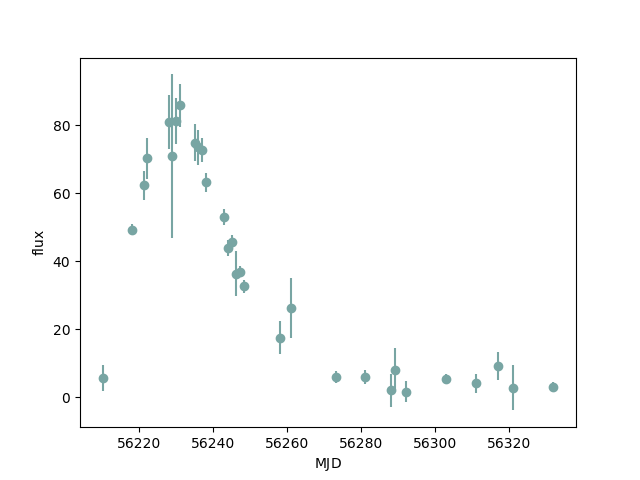

In [110]:
cur.execute("""select t, flux, dflux 
               from rawPhot
               where objId = 10 and pb = 'g'""")

data = cur.fetchall()
data = np.array(data)

fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], data[:,2], fmt = 'o', color = '#78A5A3')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")

Now that we have loaded the raw observations, we need to create a new table to store summary statistics for each object. This table will include everything we've added to the `ANTARESlc` class. 

In [140]:
cur.execute("""drop table if exists lcFeats""") # drop the table if it already exists
cur.execute("""create table lcFeats(
                id integer primary key,
                objId int,
                gStd float,
                rStd float,
                iStd float,
                zStd float,
                gAmp float, 
                rAmp float, 
                iAmp float, 
                zAmp float, 
                gMAD float,
                rMAD float,
                iMAD float,                
                zMAD float,                
                gBeyond float,
                rBeyond float,
                iBeyond float,
                zBeyond float,
                gMinusR float,
                rMinusI float,
                iMinusZ float,
                FOREIGN KEY(objId) REFERENCES rawPhot(objId)
                ) 
""")

The above procedure should look familiar to above, with one exception: the addition of the `foreign key` in the `lcFeats` table. The inclusion of the `foreign key` ensures a connected relationship between `rawPhot` and `lcFeats`. In brief, a row cannot be inserted into `lcFeats` unless a corresponding row, i.e. `objId`, exists in `rawPhot`. Additionally, rows in `rawPhot` cannot be deleted if there are dependent rows in `lcFeats`. 

**Problem 3d**

Calculate features for every source in `rawPhot` and insert those features into the `lcFeats` table.

In [141]:
for filename in filenames:
    lc = ANTARESlc(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    lc.filter_flux()
    lc.weighted_mean_flux()
    lc.normalized_flux_std()
    lc.normalized_amplitude()
    lc.normalized_MAD()
    lc.normalized_beyond_1std()
    lc.mean_colors()
    
    feats = (objId, lc.gStd, lc.rStd, lc.iStd, lc.zStd, 
            lc.gAmp,  lc.rAmp,  lc.iAmp,  lc.zAmp,  
            lc.gMAD, lc.rMAD, lc.iMAD, lc.zMAD, 
            lc.gBeyond, lc.rBeyond, lc.iBeyond, lc.zBeyond, 
            lc.gMinusR, lc.rMinusI, lc.iMinusZ)

    cur.execute("""insert into lcFeats(objId, 
                                       gStd, rStd, iStd, zStd, 
                                       gAmp,  rAmp,  iAmp,  zAmp,  
                                       gMAD, rMAD, iMAD, zMAD, 
                                       gBeyond, rBeyond, iBeyond, zBeyond, 
                                       gMinusR, rMinusI, iMinusZ) values {}""".format(feats))

ZeroDivisionError: division by zero

In [143]:
lc.rFlux

Series([], Name: flux, dtype: float64)